In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

from collections import defaultdict
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pattern import web
import dateutil.parser
from re import sub
from decimal import Decimal

In [5]:
def str2money(string):
    return Decimal(sub(r'[^\d.]', '', string))

def get_table(html):
    dom = web.Element(html)
    table = dom.by_id('datatable')
    return table

def get_data_rows(table):
    return [ row.by_tag('td') for row in table.by_tag('tr') if row.by_tag('td')]

def get_date_and_value(row):
    date_element, value_element = row
    date = dateutil.parser.parse(date_element.content)
    value = str2money(value_element.content)
    return date, value

def get_year_to_value(data_rows):
    year2values = defaultdict(list)
    for row in data_rows:
        date, value = get_date_and_value(row)
        year2values[date.year].append(value)
    
    for year in year2values:
        values = year2values[year]
        year2values[year] = float(np.mean(values))

    return year2values

def convert_to_df(table, columns):
    data_rows = get_data_rows(table)
    year2value = get_year_to_value(data_rows)
    df = pd.DataFrame.from_dict(year2value, orient='index')
    df = df.sort_index(axis=0)
    df.columns = columns
    return df

def extract_df(url, columns):
    website_html = web.download(url, unicode=True)
    table = get_table(website_html)
    return convert_to_df(table, columns)

def plot(df, title, xlabel, ylabel, columns):
    df.plot()
    plt.legend(loc='best')
    plt.xlabel(xlabel)
    plt.xticks(rotation=70)
    plt.ylabel(ylabel)
    plt.title(title)

def extract_and_plot(url, title, xlabel, ylabel, columns):
    df = extract_df(url, columns)
    plot(df, title, xlabel, ylabel, columns)

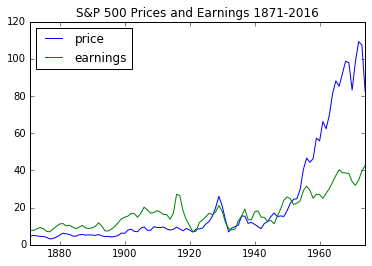

In [6]:
prices = extract_df('http://www.multpl.com/s-p-500-historical-prices/table/by-month', ['price'])
earnings = extract_df('http://www.multpl.com/s-p-500-earnings/table?f=m', ['earnings'])
price_and_earnings = pd.concat([prices, earnings], axis=1)
price_and_earnings.plot()
plt.title("S&P 500 Prices and Earnings 1871-2016")


# extract_and_plot(
#     url='http://www.multpl.com/s-p-500-historical-prices/table/by-month',
#     title="S&P 500 Historical Prices 1871-2016",
#     xlabel="Year",
#     ylabel="Price ($)",
#     columns=['price'])

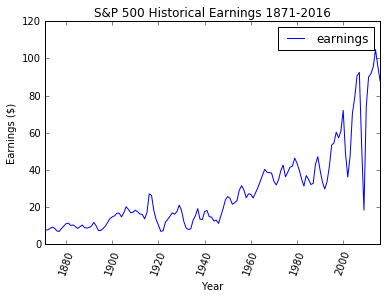

In [153]:
extract_and_plot(
    url='http://www.multpl.com/s-p-500-earnings/table?f=m',
    title="S&P 500 Historical Earnings 1871-2016",
    xlabel="Year",
    ylabel="Earnings ($)",
    columns=['earnings'])